In [12]:
import numpy as np
import pandas as pd

df = pd.read_csv('train.csv')
df

,Category,Text
0,Accountant,education omba executive leadership university...
1,Accountant,howard gerrard accountant deyjobcom birmingham...
2,Accountant,kevin frank senior accountant inforesumekraftc...
3,Accountant,place birth nationality olivia ogilvy accounta...
4,Accountant,stephen greet cpa senior accountant 9 year exp...
...,...,...
13384,Web Designing,jessica claire montgomery street san francisco...
13385,Web Designing,jessica claire montgomery street san francisco...
13386,Web Designing,summary jessica claire 100 montgomery st 10th ...
13387,Web Designing,jessica claire montgomery street san francisco...


**using specific numpy library because when i previously tried to import gensim the numpy version was causing the error it mentioned that the version isn't compatible and error suggested this version**

In [3]:
%pip install --upgrade numpy==1.26.4 gensim

   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ------ --------------------------------- 2.6/15.5 MB 18.9 MB/s eta 0:00:01
   ---------- ----------------------------- 4.2/15.5 MB 16.8 MB/s eta 0:00:01
   -------------- ------------------------- 5.5/15.5 MB 9.6 MB/s eta 0:00:02
   ----------------- ---------------------- 6.8/15.5 MB 8.6 MB/s eta 0:00:02
   ------------------- -------------------- 7.6/15.5 MB 7.8 MB/s eta 0:00:02
   ---------------------- ----------------- 8.9/15.5 MB 7.2 MB/s eta 0:00:01
   ------------------------- -------------- 10.0/15.5 MB 6.9 MB/s eta 0:00:01
   --------------------------- ------------ 10.7/15.5 MB 6.6 MB/s eta 0:00:01
   ------------------------------- -------- 12.1/15.5 MB 6.5 MB/s eta 0:00:01
   --------------------------------- ------ 12.8/15.5 MB 6.3 MB/s eta 0:00:01
   ----------------------------------- ---- 13.9/15.5 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------  15.2/15.5 MB 6.1 MB/s eta 0:00:0

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gensim

### Loading Pre-trained Word2Vec Embeddings

loading the pre-trained Word2Vec model `word2vec-google-news-300` from the `gensim` library’s dataset API.  
This model contains 300-dimensional embeddings trained on Google News data

In [ ]:
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')
embedding_dim = word2vec.vector_size

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
print(embedding_dim)

300


In [21]:
embed_dim = 300
num_heads = 4
ff_hidden_dim = 256
num_classes = 43
num_layers = 2
max_len = 100
num_epochs = 12
batch_size = 32
learning_rate = 5e-4

### Tokenizing Text and Converting to Embeddings

- `tokenize(text)`: Converts the input text to lowercase and splits it into words (tokens).
- `text_to_embedding(text, word2vec, max_len)`:  
  This converts a given text into a fixed-length sequence of word vectors using the pre-trained Word2Vec embeddings.  

In [22]:
def tokenize(text):
    return text.lower().split()

def text_to_embedding(text, word2vec, max_len):
    tokens = tokenize(text)
    vectors = []
    for token in tokens:
        if token in word2vec:
            vectors.append(word2vec[token])
        else:
            vectors.append(np.zeros(embedding_dim))
    if len(vectors) < max_len:
        vectors += [np.zeros(embedding_dim)] * (max_len - len(vectors))
    else:
        vectors = vectors[:max_len]
    return np.array(vectors)

In [23]:
import torch
import math
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()

        # Create a matrix of shape (max_len, d_model) filled with zeros
        pe = torch.zeros(max_len, d_model)

        # Create a tensor with position indices (0, 1, 2, ..., max_len-1)
        position = torch.arange(0, max_len).unsqueeze(1)

        # Compute the division term (different frequencies for each dimension)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # Apply sin to even indices in the embedding dimension
        for i in range(0, d_model, 2):
            pe[:, i] = torch.sin(position[:, 0] * div_term[i // 2])

        # Apply cos to odd indices in the embedding dimension
        for i in range(1, d_model, 2):
            pe[:, i] = torch.cos(position[:, 0] * div_term[i // 2])

        # Add an extra batch dimension for broadcasting during addition
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        # Add positional encoding to the input embeddings
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        # Make sure embed_dim is divisible by num_heads
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear layer to project input into Q, K, and V
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)

        # Linear layer to project concatenated head outputs back to embed_dim
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()

        # Project input into Q, K, V
        # Output shape: (batch_size, seq_len, embed_dim * 3)
        qkv = self.qkv_proj(x)

        # Split into 3 parts along the last dimension (Q, K, V)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)

        # Rearrange dimensions for attention computation
        # Shape: (3, batch_size, num_heads, seq_len, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # Unpack into Q, K, V
        Q, K, V = qkv[0], qkv[1], qkv[2]

        # Compute scaled dot-product attention scores
        # Shape: (batch_size, num_heads, seq_len, seq_len)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        attn_weights = F.softmax(attn_scores, dim=-1)

        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.permute(0, 2, 1, 3)
        attn_output = attn_output.reshape(batch_size, seq_len, embed_dim)

        output = self.out_proj(attn_output)

        return output


**Why permute to (2, 0, 3, 1, 4) and then later to something else?**


1.   First permute:
```python
qkv = qkv.permute(2, 0, 3, 1, 4)
```
- From `(batch_size, seq_len, 3, num_heads, head_dim)` to `(3, batch_size, num_heads, seq_len, head_dim)`

- Allows separating Q, K, V by indexing along first dimension
2.   Later permute:
```python
attn_output = attn_output.permute(0, 2, 1, 3)
```
- After attention calculation, `attn_output` shape is `(batch_size, num_heads, seq_len, head_dim)`

- This permutes to `(batch_size, seq_len, num_heads, head_dim)` for concatenating heads along the embedding dimension




### Transformer Block

This defines a single encoder block of a Transformer model. It has:

- **Multi-head self-attention:** To let the model focus on different parts of the input sequence simultaneously.
- **Layer normalization:** Applied after adding the attention output back to the input (residual connection).
- **Feedforward network:** A two-layer fully connected network with ReLU activation in between.
- **Second layer normalization:** After adding the feedforward output back (another residual connection).
- **Dropout:** Applied after attention and feedforward to reduce overfitting.

In [26]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden_dim):
        super().__init__()

        # Multi-head attention
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        # Feed-forward network
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, embed_dim)
        )

        # LayerNorm for stability
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Multi-head Attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)

        # Feed-forward network with residual connection
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)

        return x

### Transformer Classifier Model

This class builds a Transformer-based text classifier with the following parts:

- **Positional Encoding:** Adds position information to the input embeddings so the model knows the order of tokens.
- **Multiple Transformer Blocks:** A stack of Transformer encoder blocks (defined earlier) to process the input sequence.
- **Global Average Pooling:** Averages the output embeddings across all tokens to get a single vector representing the whole input.
- **Dropout:** Applied before the classifier to reduce overfitting.
- **Classification Layer:** A linear layer that outputs logits for each class.

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden_dim, num_classes, num_layers, max_len):
        super().__init__()

        # Positional encoding
        self.pos_encoder = PositionalEncoding(embed_dim, max_len)

        # Stack multiple Transformer blocks
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_hidden_dim)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(0.3)
        # Final classification layer
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # 1️⃣ Add positional encoding
        x = self.pos_encoder(x)

        # 2️⃣ Pass through each Transformer block
        for layer in self.layers:
            x = layer(x)

        # 3️⃣ Global average pooling over sequence dimension (dim=1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        logits = self.classifier(x)

        return logits

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['label'] = label_encoder.fit_transform(df['Category'])

print("\nLabel Encoding Mapping:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category} → {i}")


Label Encoding Mapping:
Accountant → 0
Advocate → 1
Agriculture → 2
Apparel → 3
Architecture → 4
Arts → 5
Automobile → 6
Aviation → 7
BPO → 8
Banking → 9
Blockchain → 10
Building and Construction → 11
Business Analyst → 12
Civil Engineer → 13
Consultant → 14
Data Science → 15
Database → 16
Designing → 17
DevOps → 18
Digital Media → 19
DotNet Developer → 20
ETL Developer → 21
Education → 22
Electrical Engineering → 23
Finance → 24
Food and Beverages → 25
Health and Fitness → 26
Human Resources → 27
Information Technology → 28
Java Developer → 29
Management → 30
Mechanical Engineer → 31
Network Security Engineer → 32
Operations Manager → 33
PMO → 34
Public Relations → 35
Python Developer → 36
React Developer → 37
SAP Developer → 38
SQL Developer → 39
Sales → 40
Testing → 41
Web Designing → 42


In [14]:
df.head()

,Category,Text,label
0,Accountant,education omba executive leadership university...,0
1,Accountant,howard gerrard accountant deyjobcom birmingham...,0
2,Accountant,kevin frank senior accountant inforesumekraftc...,0
3,Accountant,place birth nationality olivia ogilvy accounta...,0
4,Accountant,stephen greet cpa senior accountant 9 year exp...,0


In [ ]:
from sklearn.model_selection import train_test_split


# Split the data (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")



Training set shape: (10711, 3)
Validation set shape: (2678, 3)


In [ ]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# train_labels_tensor = torch.tensor(train_df['label'].values, dtype=torch.long)
# val_labels_tensor = torch.tensor(val_df['label'].values, dtype=torch.long)

# train_embeddings_tensor = torch.randn(len(train_df), max_len, embed_dim)
# val_embeddings_tensor = torch.randn(len(val_df), max_len, embed_dim)

# train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
# val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


```
train_embeddings_tensor = torch.randn(len(train_df), max_len, embed_dim)
val_embeddings_tensor = torch.randn(len(val_df), max_len, embed_dim)
```
this was the error in the code because of which aggressive overfitting was happening

**in the last I have trained model with error solved**
> Lets fix this



In [38]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

def texts_to_tensor(texts, word2vec, max_len, embed_dim):
    embeddings = []
    for text in texts:
        emb = text_to_embedding(text, word2vec, max_len)
        embeddings.append(emb)
    return torch.tensor(np.array(embeddings), dtype=torch.float32)

train_embeddings_tensor = texts_to_tensor(train_df['Text'], word2vec, max_len, embed_dim)
val_embeddings_tensor = texts_to_tensor(val_df['Text'], word2vec, max_len, embed_dim)

train_labels_tensor = torch.tensor(train_df['label'].values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_df['label'].values, dtype=torch.long)

train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [39]:
import torch.optim as optim

model = TransformerClassifier(embed_dim, num_heads, ff_hidden_dim, num_classes, num_layers, max_len)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [79]:
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = accuracy_score(all_labels, all_preds)
            loop.set_postfix(loss=running_loss / len(all_labels), accuracy=acc)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)

        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted' , zero_division=0)

        print(f"\nEpoch {epoch+1} Train Loss: {epoch_loss:.4f} Acc: {accuracy_score(all_labels, all_preds)*100:.2f}% Precision: {precision*100:.2f} Recall: {recall*100:.2f} F1: {f1*100:.2f}")

        # Validation
        model.eval()
        val_preds = []
        val_labels = []
        val_loss = 0.0

        with torch.no_grad():
            loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                val_acc = accuracy_score(val_labels, val_preds)
                loop.set_postfix(val_loss=val_loss / len(val_labels), val_acc=val_acc)

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted' , zero_division=0)

        print(f"Epoch {epoch+1} Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}% Val Precision: {val_precision*100:.2f} Val Recall: {val_recall*100:.2f} Val F1: {val_f1*100:.2f}\n")


In [ ]:
# train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)
# parameters:-
# embed_dim = 300
# num_heads = 6
# ff_hidden_dim = 512
# num_classes = 43
# num_layers = 2
# max_len = 100
# num_epochs = 8
# batch_size = 64
# learning_rate = 1e-4

**I stopped the training as model was aggressively overfitting (i lost the cell output so just wrote in markdown)**

 Epoch 1/10 [Train]: 100%|██████████| 335/335 [02:22<00:00,  2.35it/s, accuracy=0.0298, loss=3.74]

Epoch 1 Train Loss: 3.7395 Acc: 2.98% Precision: 3.91 Recall: 2.98 F1: 1.92
Epoch 1 Val Loss: 3.7528 Val Acc: 2.46% Val Precision: 0.10 Val Recall: 2.46 Val F1: 0.20

Epoch 2/10 [Train]: 100%|██████████| 335/335 [02:24<00:00,  2.32it/s, accuracy=0.0389, loss=3.72]

Epoch 2 Train Loss: 3.7174 Acc: 3.89% Precision: 3.16 Recall: 3.89 F1: 2.78
Epoch 2 Val Loss: 3.7482 Val Acc: 2.28% Val Precision: 0.62 Val Recall: 2.28 Val F1: 0.70

Epoch 3/10 [Train]: 100%|██████████| 335/335 [02:21<00:00,  2.36it/s, accuracy=0.0615, loss=3.65]

Epoch 3 Train Loss: 3.6545 Acc: 6.15% Precision: 6.40 Recall: 6.15 F1: 5.02
Epoch 3 Val Loss: 3.7766 Val Acc: 2.73% Val Precision: 4.26 Val Recall: 2.73 Val F1: 1.40

Epoch 4/10 [Train]: 100%|██████████| 335/335 [02:22<00:00,  2.35it/s, accuracy=0.113, loss=3.49]

Epoch 4 Train Loss: 3.4859 Acc: 11.25% Precision: 12.16 Recall: 11.25 F1: 10.21
Epoch 4 Val Loss: 3.8425 Val Acc: 2.35% Val Precision: 2.86 Val Recall: 2.35 Val F1: 1.86

Epoch 5/10 [Train]: 100%|██████████| 335/335 [02:21<00:00,  2.38it/s, accuracy=0.202, loss=3.17]

Epoch 5 Train Loss: 3.1654 Acc: 20.17% Precision: 21.32 Recall: 20.17 F1: 19.18
Epoch 5 Val Loss: 4.0261 Val Acc: 2.65% Val Precision: 2.96 Val Recall: 2.65 Val F1: 2.03

Epoch 6/10 [Train]: 100%|██████████| 335/335 [02:21<00:00,  2.36it/s, accuracy=0.307, loss=2.71]

Epoch 6 Train Loss: 2.7085 Acc: 30.73% Precision: 31.46 Recall: 30.73 F1: 29.94
Epoch 6 Val Loss: 4.3188 Val Acc: 2.46% Val Precision: 2.52 Val Recall: 2.46 Val F1: 2.20

In [44]:
#training -2
#parameter:-
# embed_dim = 300
# num_heads = 2
# ff_hidden_dim = 128
# num_classes = 43
# num_layers = 1
# max_len = 200
# num_epochs = 8
# batch_size = 32
# learning_rate = 1e-3
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10) #less epoch to check overfitting

Epoch 1/10 [Train]: 100%|██████████| 335/335 [01:52<00:00,  2.97it/s, accuracy=0.0254, loss=3.78]



Epoch 1 Train Loss: 3.7806 Acc: 2.54% Precision: 1.64 Recall: 2.54 F1: 1.83


Epoch 1 Val Loss: 3.7654 Val Acc: 2.73% Val Precision: 0.20 Val Recall: 2.73 Val F1: 0.38



Epoch 2/10 [Train]: 100%|██████████| 335/335 [01:48<00:00,  3.09it/s, accuracy=0.0252, loss=3.76]



Epoch 2 Train Loss: 3.7605 Acc: 2.52% Precision: 1.85 Recall: 2.52 F1: 1.88


Epoch 2 Val Loss: 3.7538 Val Acc: 3.02% Val Precision: 0.93 Val Recall: 3.02 Val F1: 1.12



Epoch 3/10 [Train]: 100%|██████████| 335/335 [01:46<00:00,  3.14it/s, accuracy=0.0372, loss=3.73]



Epoch 3 Train Loss: 3.7261 Acc: 3.72% Precision: 3.95 Recall: 3.72 F1: 3.08


Epoch 3 Val Loss: 3.7863 Val Acc: 2.69% Val Precision: 1.39 Val Recall: 2.69 Val F1: 0.93



Epoch 4/10 [Train]: 100%|██████████| 335/335 [01:48<00:00,  3.09it/s, accuracy=0.0598, loss=3.65]



Epoch 4 Train Loss: 3.6520 Acc: 5.98% Precision: 6.00 Recall: 5.98 F1: 5.55


Epoch 4 Val Loss: 3.8272 Val Acc: 2.20% Val Precision: 2.72 Val Recall: 2.20 Val F1: 1.54



Epoch 5/10 [Train]: 100%|██████████| 335/335 [01:48<00:00,  3.09it/s, accuracy=0.0871, loss=3.52]



Epoch 5 Train Loss: 3.5217 Acc: 8.71% Precision: 8.64 Recall: 8.71 F1: 8.31


Epoch 5 Val Loss: 3.9441 Val Acc: 1.87% Val Precision: 2.70 Val Recall: 1.87 Val F1: 1.57



Epoch 6/10 [Train]:   7%|▋         | 24/335 [00:08<01:44,  2.99it/s, accuracy=0.176, loss=3.24]


KeyboardInterrupt: 

**Again Overfitting**



> Lets use LR Scheduler







In [40]:
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tqdm import tqdm
import numpy as np

def train_model_new(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=2):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    best_val_loss = np.inf
    best_val_f1 = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            running_loss += loss.item() * inputs.size(0)
            
            loop.set_postfix(loss=running_loss/len(all_labels))

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted', zero_division=0
        )

        print(f"\nEpoch {epoch+1} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.2f}% "
              f"Precision: {precision*100:.2f} Recall: {recall*100:.2f} F1: {f1*100:.2f}")

        # Validation
        model.eval()
        val_preds = []
        val_labels = []
        val_loss = 0.0

        with torch.no_grad():
            loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
                loop.set_postfix(val_loss=val_loss/len(val_labels))

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='weighted', zero_division=0
        )

        print(f"Epoch {epoch+1} Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}% "
              f"Val Precision: {val_precision*100:.2f} Val Recall: {val_recall*100:.2f} Val F1: {val_f1*100:.2f}\n")

        scheduler.step()

        # Early stopping based on validation loss and save best model based on F1
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

In [33]:
train_model_new(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience=num_epochs)

Epoch 1/12 [Train]: 100%|██████████| 335/335 [00:36<00:00,  9.11it/s, loss=2.82]



Epoch 1 Train Loss: 2.8173 Acc: 31.54% Precision: 33.48 Recall: 31.54 F1: 31.04


Epoch 1 Val Loss: 4.2210 Val Acc: 2.46% Val Precision: 2.06 Val Recall: 2.46 Val F1: 2.06



Epoch 2/12 [Train]: 100%|██████████| 335/335 [00:37<00:00,  8.96it/s, loss=2.07]



Epoch 2 Train Loss: 2.0724 Acc: 49.13% Precision: 49.73 Recall: 49.13 F1: 48.89


Epoch 2 Val Loss: 4.7374 Val Acc: 2.09% Val Precision: 2.06 Val Recall: 2.09 Val F1: 1.96



Epoch 3/12 [Train]: 100%|██████████| 335/335 [00:38<00:00,  8.59it/s, loss=1.41]



Epoch 3 Train Loss: 1.4088 Acc: 65.33% Precision: 65.53 Recall: 65.33 F1: 65.22


Epoch 3 Val Loss: 5.3310 Val Acc: 2.43% Val Precision: 2.30 Val Recall: 2.43 Val F1: 2.28



Epoch 4/12 [Train]: 100%|██████████| 335/335 [00:39<00:00,  8.58it/s, loss=0.764]



Epoch 4 Train Loss: 0.7640 Acc: 84.49% Precision: 84.58 Recall: 84.49 F1: 84.45


Epoch 4 Val Loss: 5.8305 Val Acc: 2.20% Val Precision: 2.23 Val Recall: 2.20 Val F1: 2.18



Epoch 5/12 [Train]: 100%|██████████| 335/335 [00:38<00:00,  8.63it/s, loss=0.459]



Epoch 5 Train Loss: 0.4592 Acc: 92.81% Precision: 92.82 Recall: 92.81 F1: 92.80


Epoch 5 Val Loss: 6.3506 Val Acc: 2.17% Val Precision: 2.28 Val Recall: 2.17 Val F1: 2.17



Epoch 6/12 [Train]: 100%|██████████| 335/335 [00:42<00:00,  7.84it/s, loss=0.251]



Epoch 6 Train Loss: 0.2508 Acc: 97.73% Precision: 97.74 Recall: 97.73 F1: 97.73


Epoch 6 Val Loss: 6.9397 Val Acc: 1.98% Val Precision: 2.00 Val Recall: 1.98 Val F1: 1.94



Epoch 7/12 [Train]: 100%|██████████| 335/335 [00:42<00:00,  7.90it/s, loss=0.106]



Epoch 7 Train Loss: 0.1061 Acc: 99.59% Precision: 99.59 Recall: 99.59 F1: 99.59


Epoch 7 Val Loss: 7.3180 Val Acc: 2.17% Val Precision: 2.24 Val Recall: 2.17 Val F1: 2.15



Epoch 8/12 [Train]: 100%|██████████| 335/335 [00:41<00:00,  8.09it/s, loss=0.0563]



Epoch 8 Train Loss: 0.0563 Acc: 99.92% Precision: 99.92 Recall: 99.92 F1: 99.92


Epoch 8 Val Loss: 7.7804 Val Acc: 2.13% Val Precision: 2.11 Val Recall: 2.13 Val F1: 2.07



Epoch 9/12 [Train]: 100%|██████████| 335/335 [00:42<00:00,  7.79it/s, loss=0.0281]



Epoch 9 Train Loss: 0.0281 Acc: 99.99% Precision: 99.99 Recall: 99.99 F1: 99.99


Epoch 9 Val Loss: 8.1676 Val Acc: 2.35% Val Precision: 2.43 Val Recall: 2.35 Val F1: 2.35



Epoch 10/12 [Train]: 100%|██████████| 335/335 [00:43<00:00,  7.65it/s, loss=0.0157]



Epoch 10 Train Loss: 0.0157 Acc: 100.00% Precision: 100.00 Recall: 100.00 F1: 100.00


Epoch 10 Val Loss: 8.3042 Val Acc: 2.24% Val Precision: 2.30 Val Recall: 2.24 Val F1: 2.24



Epoch 11/12 [Train]: 100%|██████████| 335/335 [00:42<00:00,  7.86it/s, loss=0.0124]



Epoch 11 Train Loss: 0.0124 Acc: 100.00% Precision: 100.00 Recall: 100.00 F1: 100.00


Epoch 11 Val Loss: 8.4443 Val Acc: 2.35% Val Precision: 2.35 Val Recall: 2.35 Val F1: 2.32



Epoch 12/12 [Train]: 100%|██████████| 335/335 [00:42<00:00,  7.95it/s, loss=0.0101]



Epoch 12 Train Loss: 0.0101 Acc: 100.00% Precision: 100.00 Recall: 100.00 F1: 100.00


Epoch 12 Val Loss: 8.5721 Val Acc: 2.20% Val Precision: 2.22 Val Recall: 2.20 Val F1: 2.19



### **Lets Train our model again with the error being solved!!!**

In [41]:
train_model_new(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience=2)

Epoch 1/12 [Train]: 100%|██████████| 335/335 [00:44<00:00,  7.58it/s, loss=2.86]



Epoch 1 Train Loss: 2.8587 Acc: 23.88% Precision: 25.71 Recall: 23.88 F1: 23.00


Epoch 1 Val Loss: 1.8208 Val Acc: 49.70% Val Precision: 54.66 Val Recall: 49.70 Val F1: 46.87



Epoch 2/12 [Train]: 100%|██████████| 335/335 [00:38<00:00,  8.67it/s, loss=1.5] 



Epoch 2 Train Loss: 1.5027 Acc: 60.14% Precision: 58.63 Recall: 60.14 F1: 58.96


Epoch 2 Val Loss: 1.3019 Val Acc: 65.53% Val Precision: 67.04 Val Recall: 65.53 Val F1: 64.60



Epoch 3/12 [Train]: 100%|██████████| 335/335 [00:40<00:00,  8.18it/s, loss=1.22]



Epoch 3 Train Loss: 1.2159 Acc: 67.82% Precision: 67.52 Recall: 67.82 F1: 67.39


Epoch 3 Val Loss: 1.1454 Val Acc: 69.42% Val Precision: 70.41 Val Recall: 69.42 Val F1: 68.91



Epoch 4/12 [Train]: 100%|██████████| 335/335 [00:43<00:00,  7.70it/s, loss=0.97] 



Epoch 4 Train Loss: 0.9704 Acc: 74.18% Precision: 74.16 Recall: 74.18 F1: 73.93


Epoch 4 Val Loss: 1.0738 Val Acc: 71.21% Val Precision: 73.80 Val Recall: 71.21 Val F1: 71.65



Epoch 5/12 [Train]: 100%|██████████| 335/335 [00:42<00:00,  7.97it/s, loss=0.874]



Epoch 5 Train Loss: 0.8744 Acc: 76.05% Precision: 75.91 Recall: 76.05 F1: 75.82


Epoch 5 Val Loss: 1.0790 Val Acc: 71.62% Val Precision: 73.98 Val Recall: 71.62 Val F1: 71.81



Epoch 6/12 [Train]: 100%|██████████| 335/335 [00:44<00:00,  7.61it/s, loss=0.802]



Epoch 6 Train Loss: 0.8020 Acc: 78.28% Precision: 78.19 Recall: 78.28 F1: 78.09


Epoch 6 Val Loss: 1.1047 Val Acc: 72.14% Val Precision: 73.66 Val Recall: 72.14 Val F1: 72.26

Early stopping at epoch 6


### Lets optimise it a bit more
**I asked ChatGPT how we can optimise it more, the following are the ways**

- Better Learning Rate Scheduling :-

Your current scheduler is StepLR — let’s try ReduceLROnPlateau which adapts based on validation loss or F1:
```python
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
```

- Use Weight decay
```python 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
```

- Add label Smoothing


In [42]:
# Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, pred, target):
        pred = torch.log_softmax(pred, dim=-1)
        true_dist = torch.zeros_like(pred).fill_(self.smoothing / (self.classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return self.kl_div(pred, true_dist)

### **Lets change the LR scheduler**

In [47]:
def train_model_optimized(model, train_loader, val_loader, num_classes, device, num_epochs=10, patience=3):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    best_val_f1 = 0
    patience_counter = 0

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        # === Train Phase ===
        model.train()
        train_loss, all_preds, all_labels = 0.0, [], []

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            train_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=train_loss/len(all_labels))

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"\nEpoch {epoch+1} Train Loss: {train_loss:.4f} Acc: {train_acc*100:.2f}%")

        # === Validation Phase ===
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []

        with torch.no_grad():
            loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='weighted', zero_division=0
        )

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1} Val Loss: {val_loss:.4f} Acc: {val_acc*100:.2f}% F1: {val_f1*100:.2f}")

        scheduler.step(val_f1)

        # Early stopping on validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"\n✅ Best Val F1: {best_val_f1*100:.2f}")
    return history

In [48]:
model_training_1 = train_model_optimized(
    model, train_loader, val_loader, num_classes=num_classes,
    device=device, num_epochs=10, patience=3
)

Epoch 1/10 [Train]: 100%|██████████| 335/335 [01:25<00:00,  3.93it/s, loss=0.595]



Epoch 1 Train Loss: 0.5952 Acc: 84.30%


Epoch 1 Val Loss: 1.0295 Acc: 74.87% F1: 74.89


Epoch 2/10 [Train]: 100%|██████████| 335/335 [01:32<00:00,  3.64it/s, loss=0.461]



Epoch 2 Train Loss: 0.4614 Acc: 87.58%


Epoch 2 Val Loss: 1.0476 Acc: 74.91% F1: 74.88


Epoch 3/10 [Train]: 100%|██████████| 335/335 [01:37<00:00,  3.44it/s, loss=0.391]



Epoch 3 Train Loss: 0.3907 Acc: 89.52%


Epoch 3 Val Loss: 1.0766 Acc: 74.65% F1: 74.62


Epoch 4/10 [Train]: 100%|██████████| 335/335 [01:37<00:00,  3.42it/s, loss=0.339]



Epoch 4 Train Loss: 0.3388 Acc: 90.88%


Epoch 4 Val Loss: 1.1025 Acc: 74.50% F1: 74.67
Early stopping at epoch 4

✅ Best Val F1: 74.89


**The model is overfitting**

In [49]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

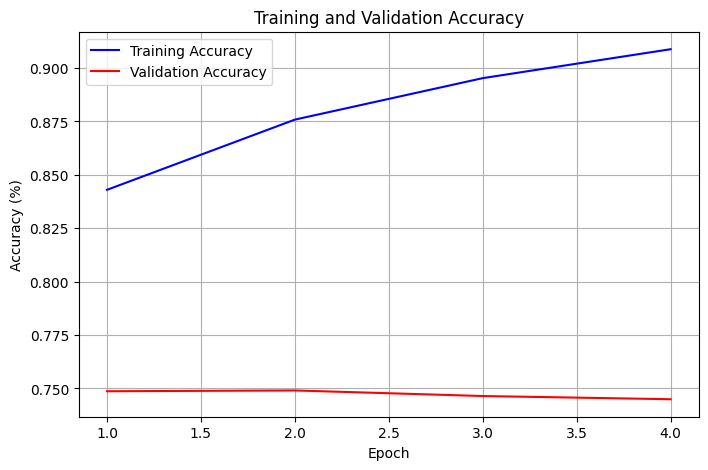

In [53]:
plot_accuracy(
    model_training_1['train_acc'], model_training_1['val_acc']
)

### Using Label Smoothing and weight decay in optimizer

In [ ]:
def train_model_optimized(model, train_loader, val_loader, num_classes, device, num_epochs=10, patience=3):
    criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    best_val_f1 = 0
    patience_counter = 0

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        # === Train Phase ===
        model.train()
        train_loss, all_preds, all_labels = 0.0, [], []

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            train_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=train_loss/len(all_labels))

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"\nEpoch {epoch+1} Train Loss: {train_loss:.4f} Acc: {train_acc*100:.2f}%")

        # === Validation Phase ===
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []

        with torch.no_grad():
            loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='weighted', zero_division=0
        )

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1} Val Loss: {val_loss:.4f} Acc: {val_acc*100:.2f}% F1: {val_f1*100:.2f}")

        scheduler.step(val_f1)

        # Early stopping on validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"\n✅ Best Val F1: {best_val_f1*100:.2f}")
    return history

### **The model is not overfitting but could not achieve better accuracy**

In [45]:
model_training = train_model_optimized(
    model, train_loader, val_loader, num_classes=num_classes,
    device=device, num_epochs=20, patience=3
)

Epoch 1/20 [Train]: 100%|██████████| 335/335 [00:41<00:00,  8.02it/s, loss=1.01]



Epoch 1 Train Loss: 1.0123 Acc: 68.62%


Epoch 1 Val Loss: 1.0608 Acc: 68.37% F1: 68.02


Epoch 2/20 [Train]: 100%|██████████| 335/335 [00:46<00:00,  7.21it/s, loss=0.935]



Epoch 2 Train Loss: 0.9351 Acc: 70.79%


Epoch 2 Val Loss: 1.0088 Acc: 68.97% F1: 68.98


Epoch 3/20 [Train]: 100%|██████████| 335/335 [00:49<00:00,  6.81it/s, loss=0.88] 



Epoch 3 Train Loss: 0.8802 Acc: 72.31%


Epoch 3 Val Loss: 1.0024 Acc: 68.89% F1: 69.37


Epoch 4/20 [Train]: 100%|██████████| 335/335 [00:54<00:00,  6.10it/s, loss=0.842]



Epoch 4 Train Loss: 0.8424 Acc: 72.92%


Epoch 4 Val Loss: 0.9912 Acc: 69.42% F1: 68.90


Epoch 5/20 [Train]: 100%|██████████| 335/335 [00:59<00:00,  5.61it/s, loss=0.827]



Epoch 5 Train Loss: 0.8273 Acc: 73.45%


Epoch 5 Val Loss: 1.0275 Acc: 67.59% F1: 67.77


Epoch 6/20 [Train]: 100%|██████████| 335/335 [01:02<00:00,  5.34it/s, loss=0.795]



Epoch 6 Train Loss: 0.7946 Acc: 74.45%


Epoch 6 Val Loss: 0.9965 Acc: 70.28% F1: 70.73


Epoch 7/20 [Train]: 100%|██████████| 335/335 [01:05<00:00,  5.14it/s, loss=0.757]



Epoch 7 Train Loss: 0.7573 Acc: 75.61%


Epoch 7 Val Loss: 1.0153 Acc: 68.78% F1: 69.14


Epoch 8/20 [Train]: 100%|██████████| 335/335 [01:12<00:00,  4.60it/s, loss=0.746]



Epoch 8 Train Loss: 0.7464 Acc: 75.41%


Epoch 8 Val Loss: 1.0065 Acc: 69.72% F1: 69.72


Epoch 9/20 [Train]: 100%|██████████| 335/335 [01:16<00:00,  4.38it/s, loss=0.729]



Epoch 9 Train Loss: 0.7286 Acc: 76.46%


Epoch 9 Val Loss: 0.9286 Acc: 71.32% F1: 71.37


Epoch 10/20 [Train]: 100%|██████████| 335/335 [01:22<00:00,  4.08it/s, loss=0.723]



Epoch 10 Train Loss: 0.7226 Acc: 76.35%


Epoch 10 Val Loss: 0.9827 Acc: 69.75% F1: 69.47


Epoch 11/20 [Train]: 100%|██████████| 335/335 [01:23<00:00,  4.03it/s, loss=0.69] 



Epoch 11 Train Loss: 0.6898 Acc: 77.23%


Epoch 11 Val Loss: 0.9443 Acc: 71.25% F1: 70.80


Epoch 12/20 [Train]: 100%|██████████| 335/335 [01:31<00:00,  3.67it/s, loss=0.68] 



Epoch 12 Train Loss: 0.6802 Acc: 77.65%


Epoch 12 Val Loss: 0.9479 Acc: 70.13% F1: 70.38
Early stopping at epoch 12

✅ Best Val F1: 71.37
